In [20]:
# import couchdb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings; warnings.filterwarnings('ignore')
%matplotlib inline
%config InlineBackend.figure_format ='retina'
fontdict={'fontsize': 20,'fontweight' : 3}

# couch = couchdb.Server()
# couch.resource.credentials = ('admin', '2017')
# db = couch['raw_house']

In [21]:
# t = pd.read_csv('raw.csv')

# Background 

## Factors that impact on house price

### Macro-Factors Affecting Home Prices

- Economic Indicators
- Interest Rates
- Investors
- Mortgage interest tax credit 
- local builder activity 
- zoning restrictions

### Micro-Factors Affecting Real Estate Prices
- Property Location 
    - "hedonic pricing" -- for most homes, some key factors that impact your life and your lifestyle
- Updates and Upgrades
- Inspection Report
- Neighborhood

## Tools

- Beautiful Soup
- CouchDB
- Pandas
- Seaborn
- Sci-kit learn

---
# Load data

Features:
- Price of property. 
- Land area. House area if it is apartment.
- Address of property.
- Number of car parking.
- Number of bedrooms.
- Number of bathrooms.
- Longitude of property.
- Latitude of property.
- Sold date with sold type. Sold type including auction and private treaty.
- Property type. House, townhouse or apartment.

In [23]:
# df_raw = pd.DataFrame(columns=['price', 'landsize', 'address', 'park', 'bed', 
#                            'bath', 'longitude', 'latitude', 'date', 'property_type'])

# for i, item in enumerate(db.view('t/viewname', skip=40000,limit=10000)):
#     df_raw.loc[i] = item.value
    
# df_raw.to_csv('raw_house_50k.csv', index=False)

In [24]:
df1 = pd.read_csv('raw_house_10k.csv')
df2 = pd.read_csv('raw_house_20k.csv')
df3 = pd.read_csv('raw_house_30k.csv')
df4 = pd.read_csv('raw_house_40k.csv')
df5 = pd.read_csv('raw_house_50k.csv')

df = pd.concat([df1, df2, df3, df4, df5], axis=0)

In [25]:
df.head(2)

,price,landsize,address,park,bed,bath,longitude,latitude,date,property_type
0,"$956,000",Land area 722 m2,"13 Altona Street, Heidelberg Heights VIC 3081",2,4,1,145.056458,-37.747680,Sold at auction 20 August 2016,House
1,"$876,000\r\n price from APM PriceFinder",Land area 560 m2,"16 Shakespeare Grove, Heidelberg Heights VIC 3081",2,4,2,145.055573,-37.736565,Sold at auction 19 March 2016,House


---
# Data clean

In [26]:
print 'Data frame shape:', df.shape

Data frame shape: (44053, 10)


Check if there is any duplicates, if so then drop.

In [27]:
print 'There are ', df.duplicated().sum(), ' duplicates.'

There are  7259  duplicates.


In [28]:
df.drop_duplicates(inplace=True)

In [29]:
print 'Data frame infomation:'
df.info()

Data frame infomation:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 36794 entries, 0 to 4052
Data columns (total 10 columns):
price            36794 non-null object
landsize         36794 non-null object
address          36794 non-null object
park             36794 non-null object
bed              36794 non-null int64
bath             36794 non-null object
longitude        36794 non-null float64
latitude         36794 non-null float64
date             36794 non-null object
property_type    36706 non-null object
dtypes: float64(2), int64(1), object(7)
memory usage: 3.1+ MB


In [30]:
# trim price column
def trimPrice(x):
    num = x.strip().replace('$','').replace(',','')
    num = num.split()[0]
    try: 
        return int(num)
    except:
        return np.nan

df.price = df.price.map(trimPrice)
df.dropna(inplace=True)

In [31]:
# trim landsize
def trimLandsize(x):
    x = x.split('\n')[0].replace('m2', '').split()[-1]
    try:
        return int(x)
    except:
        return np.nan
    
df.landsize = df.landsize.map(trimLandsize)
df.dropna(inplace=True)

In [32]:
# trim address
def getSuburb(x):
    return ' '.join(x.lower().split(',')[-1].split()[:-2])

df['suburb'] = df.address.map(getSuburb)

In [33]:
def trimAddress(x):
    return x.split(',')[0]
df.address = df.address.map(trimAddress)

In [34]:
# trim park, bed, bath
def toInt(x):
    try:
        return int(x)
    except:
        return 0
df.park = df.park.map(toInt)
df.bed = df.bed.map(toInt)
df.bath = df.bath.map(toInt)

In [35]:
# get geo
df['geo'] = zip(df.longitude, df.latitude)
df.drop(['longitude', 'latitude'], axis=1, inplace=True)

In [36]:
# get sold type
def soldType(x):
    return x.split()[:-3][-1]
df['soldtype'] = df.date.map(soldType)

In [37]:
# trim date
def trimDate(x):
    return ' '.join(x.split()[-3:])

df['date'] = df.date.map(trimDate)
df.date = pd.to_datetime(df.date)

In [38]:
# trim property_type
def trimPropertyType(x):
    tp = x.split('/')[0].split(',')[0].strip()
    if tp == 'House':
        return 'House'
    elif tp == 'Townhouse':
        return 'Townhouse'
    elif tp == 'Apartment':
        return 'Apartment'
    return np.nan

df.property_type = df.property_type.map(trimPropertyType)

In [39]:
# calculate distance to melb_cbd
from math import sin, cos, sqrt, atan2, radians
def calcdist(value):
    a, b = value
    lat1 = radians(-37.810817)
    lon1 = radians(144.963135)
    lat2 = radians(float(b))
    lon2 = radians(float(a))

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    
    R = 6373.0
    distance = R * c

    return distance
df['dist2cbd'] = df.geo.map(calcdist)
df.drop('geo', axis=1, inplace=True)

In [40]:
data = df.dropna()
print 'Data frame shape after trim:',data.shape

Data frame shape after trim: (27054, 11)


# EDA

## Identify outliers of `price` column

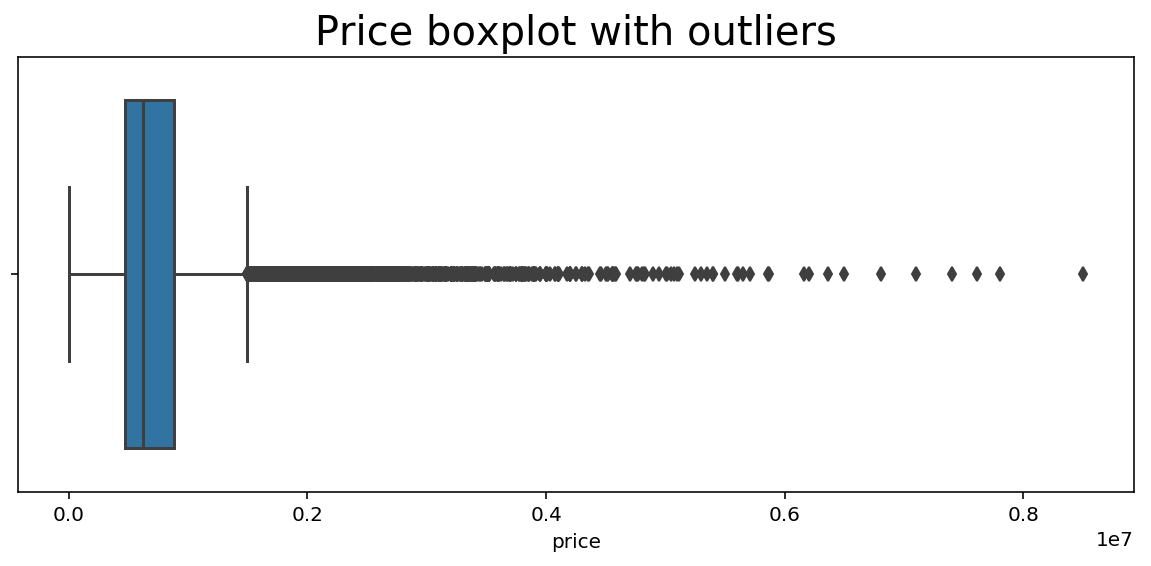

In [41]:
fig, ax = plt.subplots(figsize=(10,4))
ax.set_title('Price boxplot with outliers', fontdict=fontdict)
sns.boxplot(data.price);

keep only the ones that are within +3 to -3 standard deviations in the column `price`.

In [42]:
# remove outliers in price column
# keep only the ones that are within +3 to -3 standard deviations in the column 'price'.
data = data[np.abs(data.price-data.price.mean())<=(3*data.price.std())]

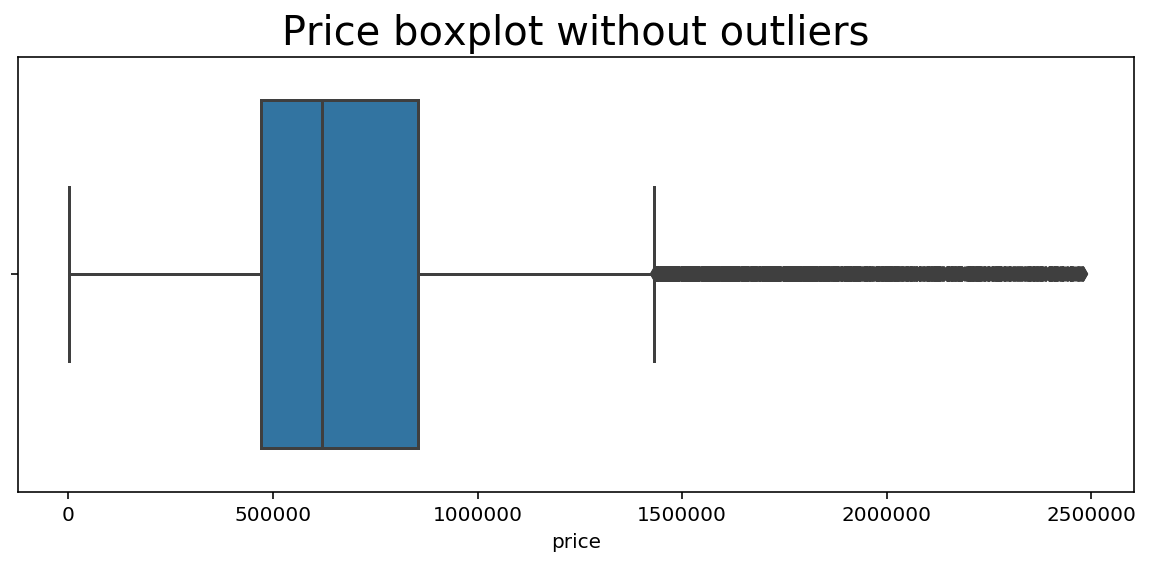

In [43]:
fig, ax = plt.subplots(figsize=(10,4))
ax.set_title('Price boxplot without outliers', fontdict=fontdict)
sns.boxplot(data.price);

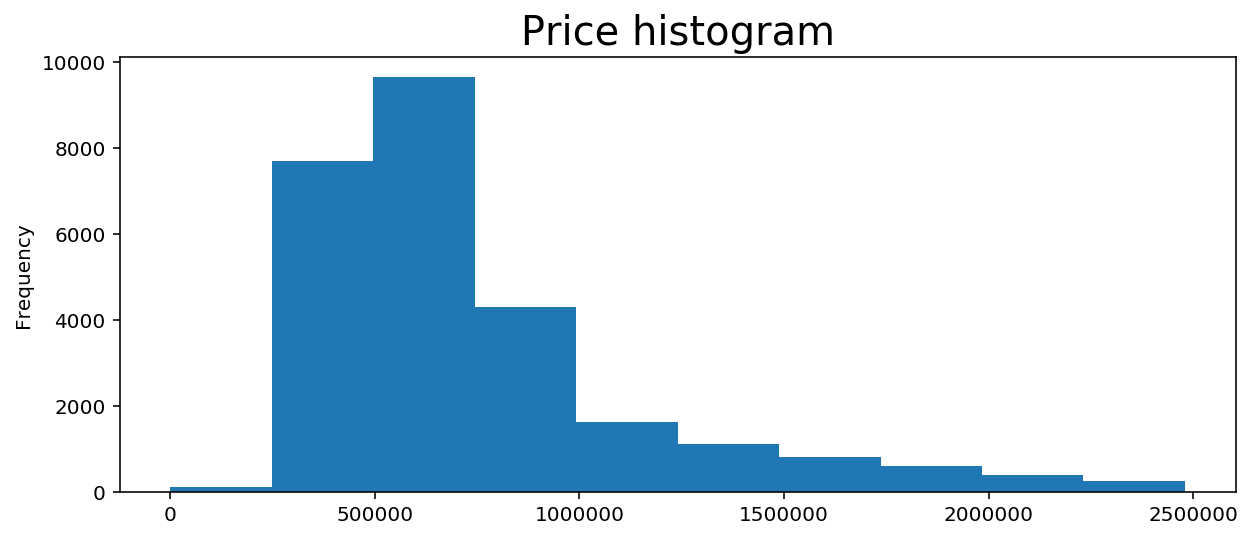

In [44]:
fig, ax = plt.subplots(figsize=(10,4))
ax.set_title('Price histogram', fontdict=fontdict)
data.price.plot(kind='hist');

Property with price under 200000. Either typo of price or small empty land. 

In [45]:
data[data.price < 200000].head(2)

,price,landsize,address,park,bed,bath,date,property_type,suburb,soldtype,dist2cbd
96,180000.0,347.0,2/28 Morotai Parade,1,2,1,2013-09-10,Apartment,heidelberg west,treaty,9.947232
1480,835.0,301.0,1/84 Strathallan Road,2,4,3,2015-09-12,House,macleod,auction,13.668933


In [46]:
data = data[~(data.price < 200000)]

## Identify outliers of `landsize` column

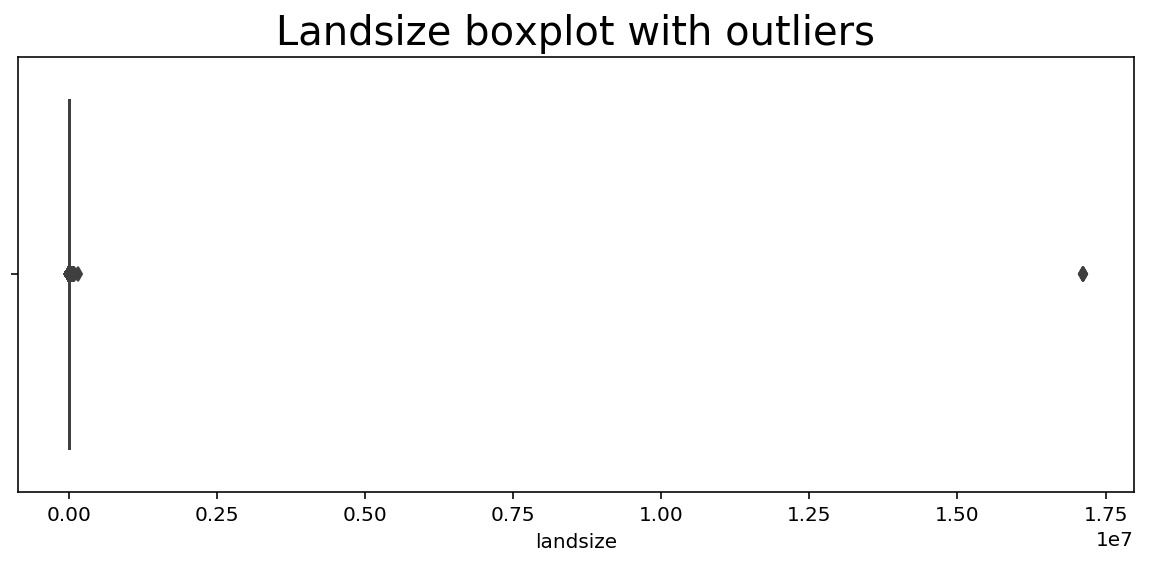

In [47]:
# check out land size
fig, ax = plt.subplots(figsize=(10,4))
ax.set_title('Landsize boxplot with outliers', fontdict=fontdict)
sns.boxplot(data.landsize)
data = data[np.abs(data.landsize-data.landsize.mean())<=(2*data.landsize.std())]

keep only the ones that are within +2 to -2 standard deviations in the column `landsize`.


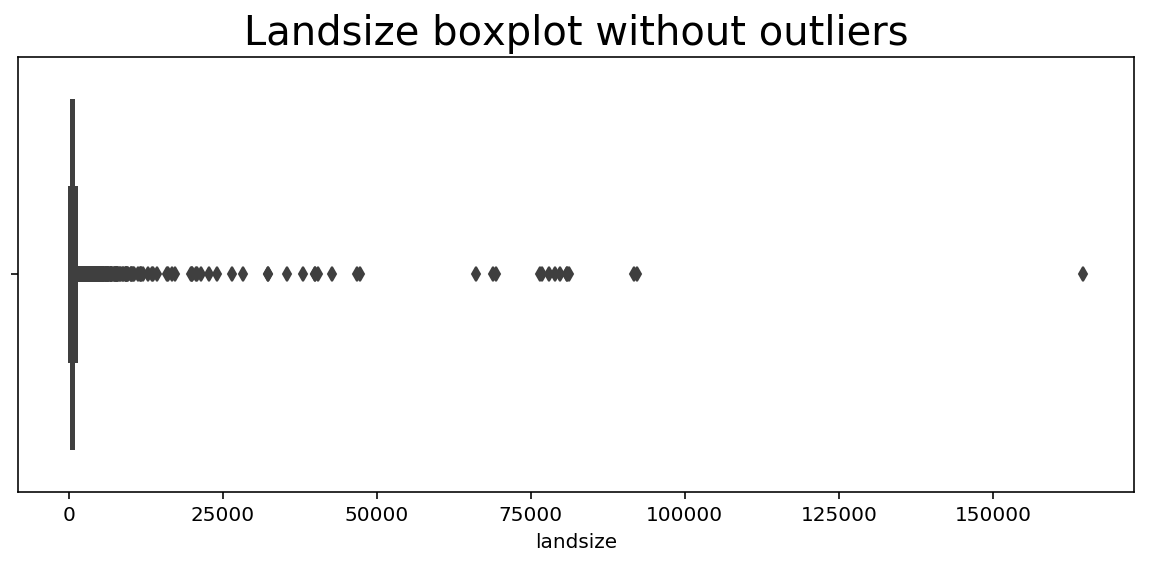

In [48]:
fig, ax = plt.subplots(figsize=(10,4))
ax.set_title('Landsize boxplot without outliers', fontdict=fontdict)
sns.boxplot(data.landsize);

## Distance to Melbourne CBD

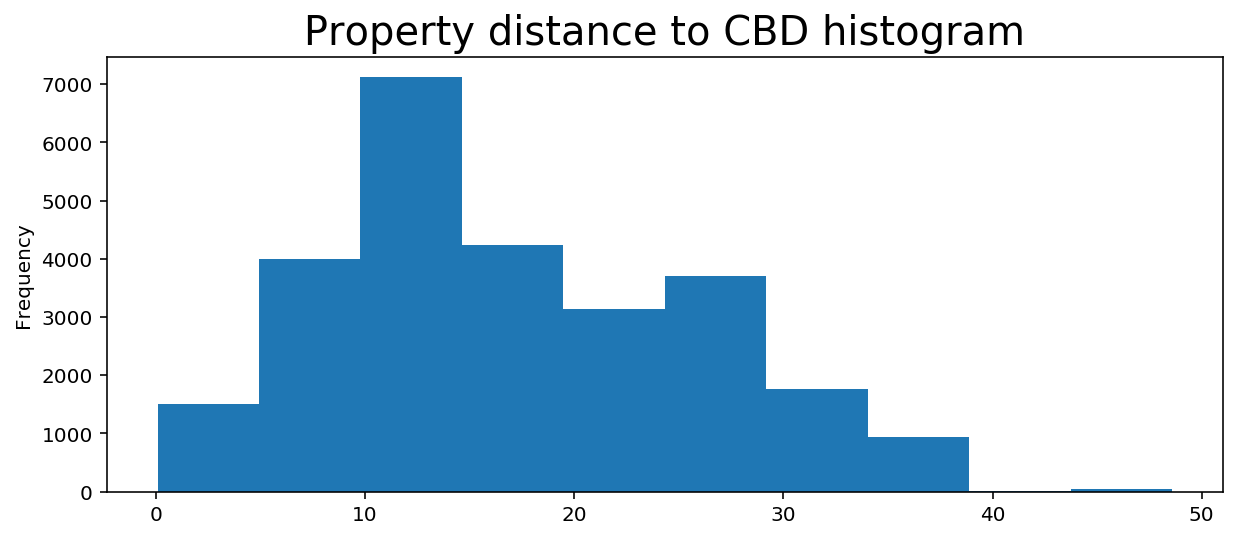

In [49]:
fig, ax = plt.subplots(figsize=(10,4))
ax.set_title('Property distance to CBD histogram', fontdict=fontdict)
data.dist2cbd.plot(kind='hist');

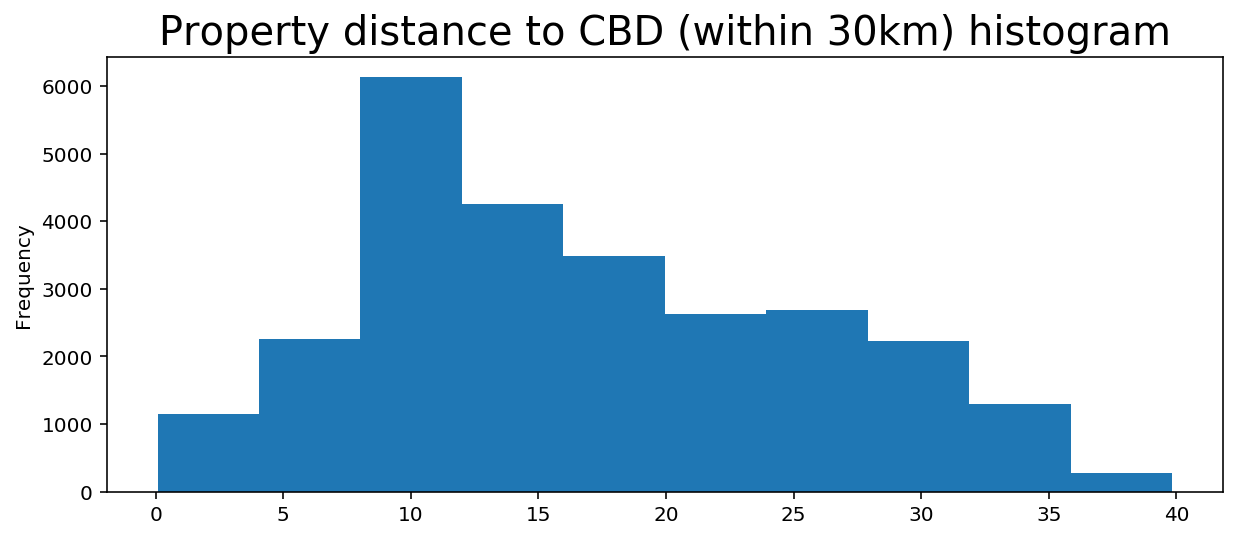

In [50]:
data = data[data.dist2cbd <= 40]
fig, ax = plt.subplots(figsize=(10,4))
ax.set_title('Property distance to CBD (within 30km) histogram', fontdict=fontdict)
data.dist2cbd.plot(kind='hist');

## Date related figures

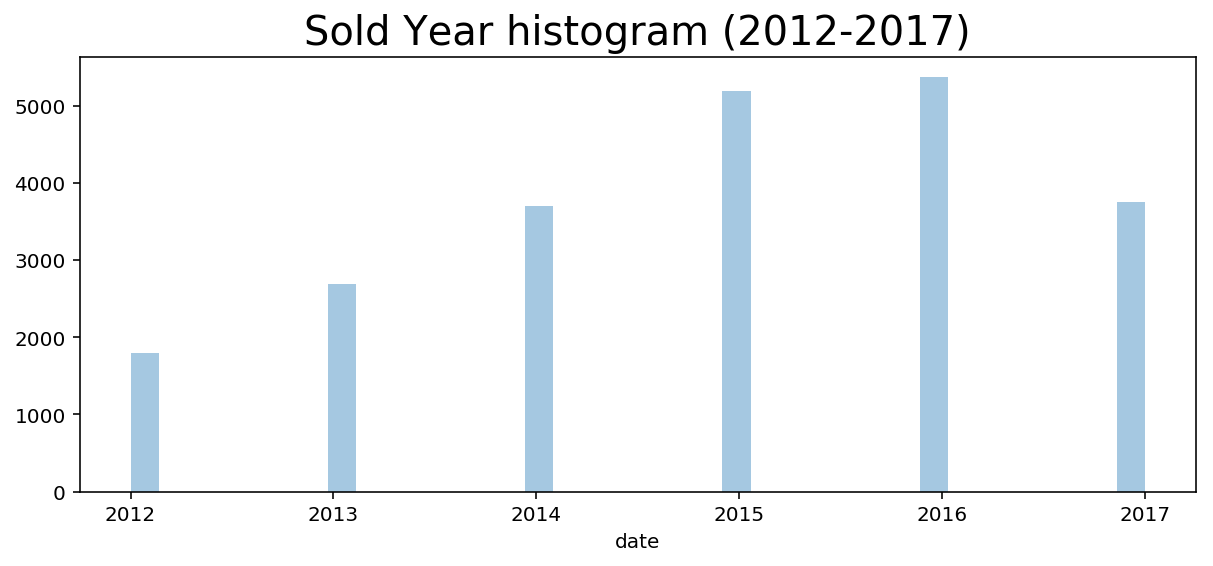

In [51]:
fig, ax = plt.subplots(figsize=(10,4))
ax.set_title('Sold Year histogram (2012-2017)', fontdict=fontdict)
data = data[data.date.dt.year > 2011]
sns.distplot(data.date.dt.year, kde=False);

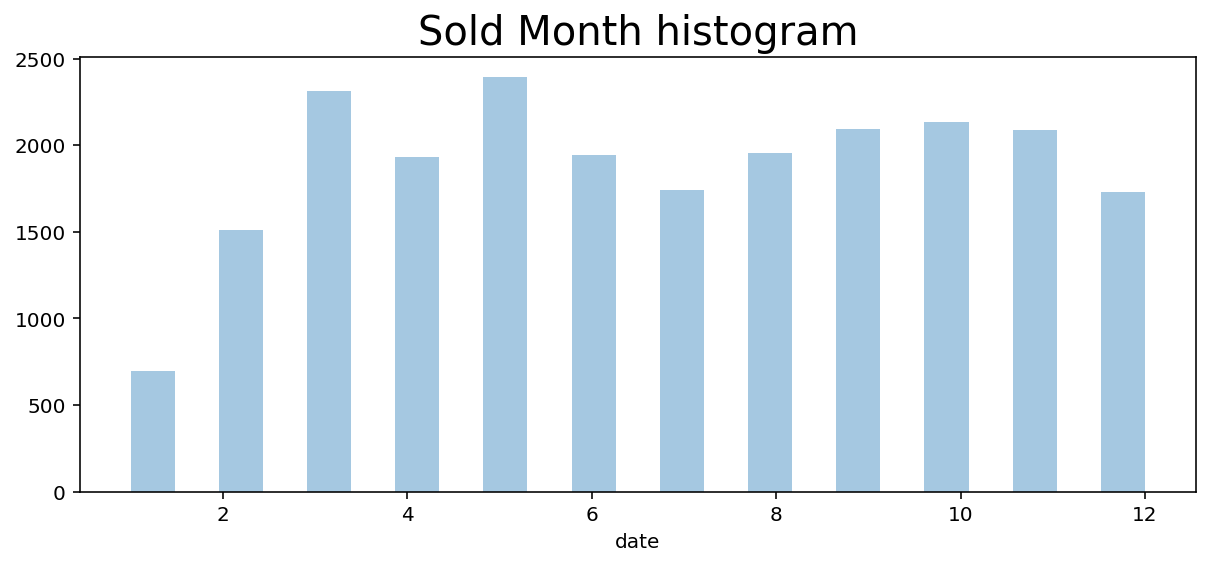

In [52]:
fig, ax = plt.subplots(figsize=(10,4))
ax.set_title('Sold Month histogram', fontdict=fontdict)
sns.distplot(data.date.dt.month, kde=False, bins=23);

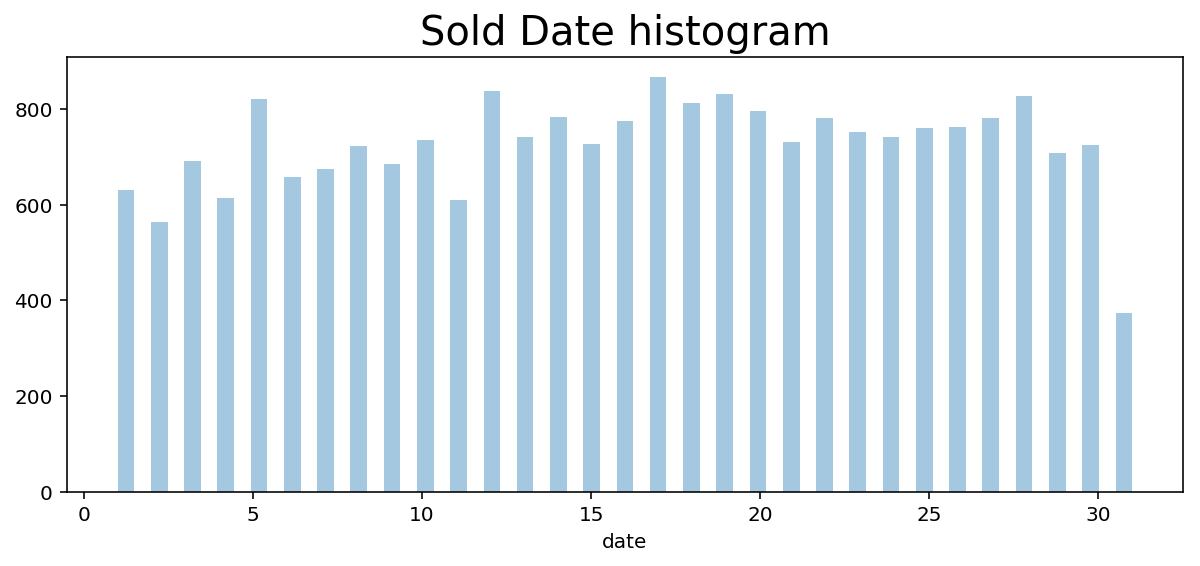

In [53]:
fig, ax = plt.subplots(figsize=(10,4))
ax.set_title('Sold Date histogram', fontdict=fontdict)
sns.distplot(data.date.dt.day, kde=False, bins=61);

## Map view

In [73]:
g = data.groupby(by='suburb').count().reset_index()
gg = g[['price', 'suburb']]
gg['name'] = gg.suburb
gg.suburb = gg.suburb.str.title()

In [72]:
gg.suburb.nunique()

148

In [70]:
import folium, os

In [71]:
state_geo = os.path.join('data', 'mel.geojson')


state_data = gg

m = folium.Map(location=[-37.817341, 145.033777], zoom_start=11)

m.choropleth(
    geo_data=state_geo,
    name='choropleth',
    data=state_data,
    columns=['suburb', 'price'],
    key_on='feature.properties.name',
    fill_color='YlOrRd',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='---',
)


folium.LayerControl().add_to(m)

m

## Heatmap

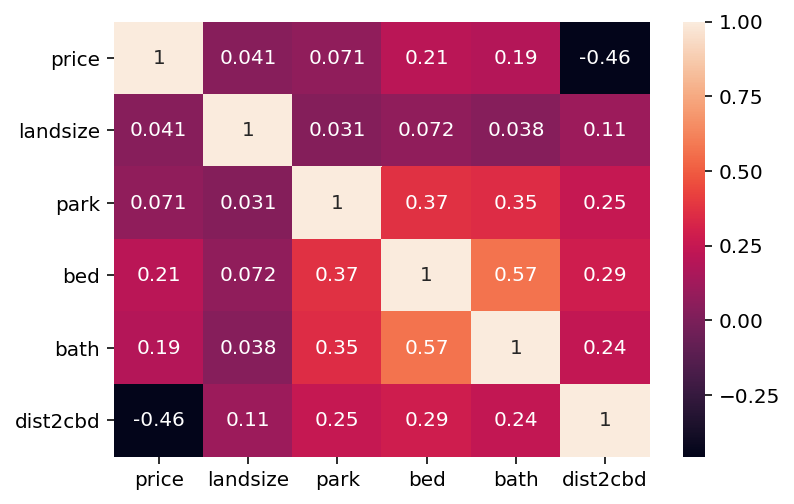

In [54]:
sns.heatmap(data.corr(), annot=True);

# Categorical feature to dummies

In [55]:
print 'Property type:', data.property_type.unique().tolist()
print 'Sold type:', data.soldtype.unique().tolist()

Property type: ['House', 'Townhouse', 'Apartment']
Sold type: ['auction', 'treaty', 'Sold']


In [56]:
propertyTpye_dummies = pd.get_dummies(data.property_type)
soldTpye_dummies = pd.get_dummies(data.soldtype)

In [57]:
data = pd.concat([data, propertyTpye_dummies, soldTpye_dummies], axis=1)
data = data.drop(['property_type', 'soldtype'], axis=1)

---
# Linear model

In [58]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, LinearRegression, RidgeCV, LassoCV, ElasticNetCV

## Basic feature

Including: landsize, park, bedroom, bathroom, house type, sold type, distance to cbd

### Linear regression

In [59]:
X = data[['landsize', 'park', 'bed', 'bath', 'House', 'Townhouse', 'treaty', 'dist2cbd']]
y = data.price.values
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.5, random_state=49)

ss = StandardScaler()
ss = ss.fit(Xtrain)

Xtrain = ss.transform(Xtrain)
Xtest = ss.transform(Xtest)

lr = LinearRegression()
print 'Mean of cross validation score (cv=10) for linear regression is', np.mean(cross_val_score(lr.fit(Xtrain, ytrain), Xtest, ytest, cv=10))

Mean of cross validation score (cv=10) for linear regression is 0.392232992461


In [60]:
y = y
yh = lr.predict(Xtest)
result = pd.DataFrame([y,yh]).T
result.columns = ['y', 'yhat']

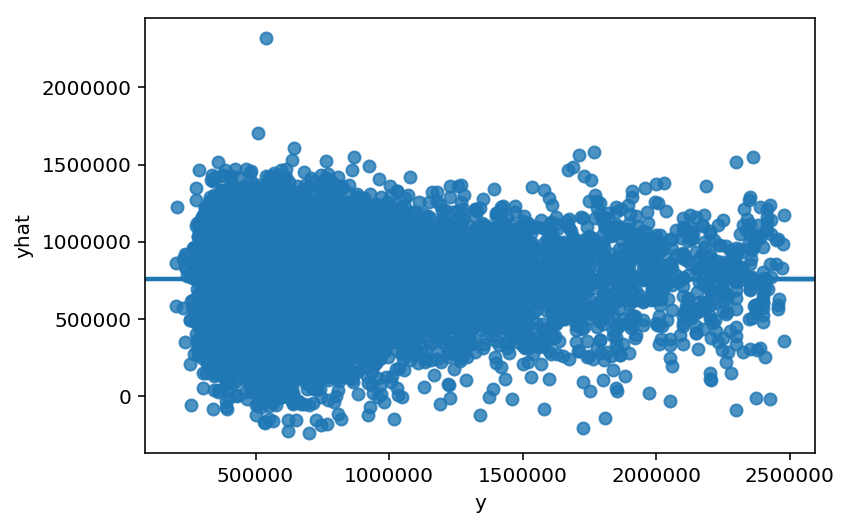

In [61]:
sns.regplot(x="y", y="yhat", data=result);

In [62]:
result[(result.yhat > 2000000)]

,y,yhat
1513,540000.0,2.321128e+06


In [63]:
data.iloc[[1494, 2892, 3158, 3270, 4814],:]

,price,landsize,address,park,bed,bath,date,suburb,dist2cbd,Apartment,House,Townhouse,Sold,auction,treaty
2226,647000.0,691.0,14 Leura Avenue,1,3,1,2013-06-25,rosanna,12.990504,0,1,0,0,0,1
4282,1600000.0,375.0,21 King Street,2,3,2,2015-11-07,camberwell,9.324390,0,1,0,0,1,0
4988,1705000.0,717.0,41 Ashburton Road,2,3,2,2015-08-15,glen iris,10.897981,0,1,0,0,1,0
5186,1890000.0,746.0,145 High Street,2,4,2,2015-03-29,glen iris,11.376334,0,1,0,0,0,1
8079,440000.0,600.0,11 Resort Boulevard,2,4,2,2014-07-28,doreen,26.802694,0,1,0,0,0,1


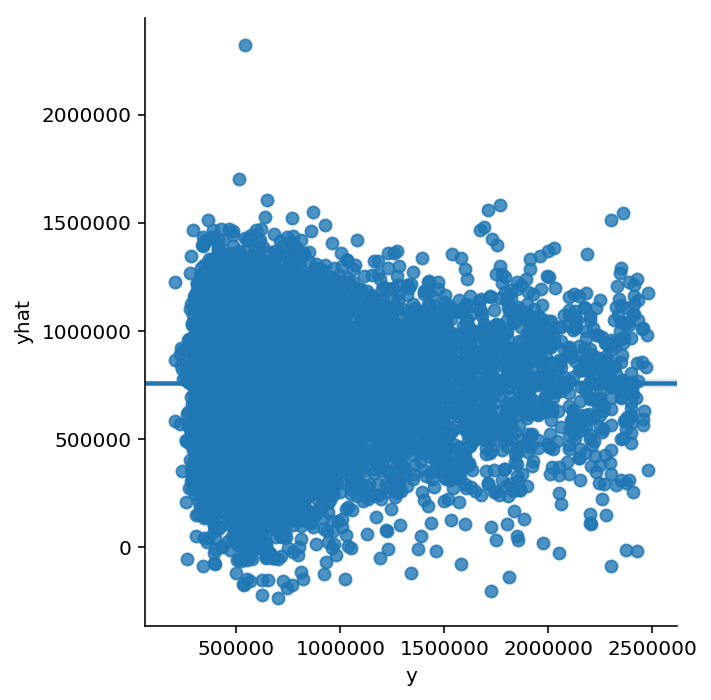

In [64]:
rf = result.drop([1494, 2892, 3158, 3270, 4814], axis=0)
sns.lmplot(x="y", y="yhat", data=rf);

This linear model performance very poorly when property price is higher than 2 million.

Good predict: residual of predicted property price and actual price is less than 20% of its actual price.

Good predict 0.120763935154


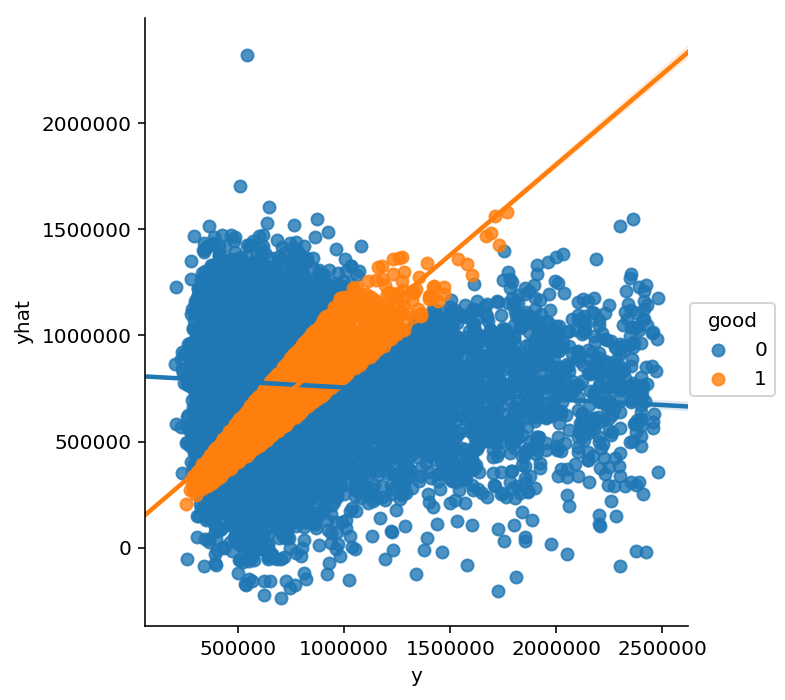

In [65]:
rf['re'] = rf.y - rf.yhat
rf['res_pre'] = rf.re.astype(float) / rf.y
rf['good'] = rf.res_pre.map(lambda x: 1 if (x<=0.2) and (x>=-0.2) else 0)
print 'Good predict', float(rf[rf.good == 1].shape[0]) / rf.shape[0]
sns.lmplot(x="y", y="yhat", data=rf, hue='good');

### Ridge, Lasso, ElasticNet

In [66]:
ridge_alphas = np.logspace(0, 1, 200)
optimal_ridge = RidgeCV(alphas=ridge_alphas, cv=10)
optimal_ridge.fit(Xtrain, ytrain)

ridge = Ridge(alpha=optimal_ridge.alpha_)
print 'Mean of cross validation score (cv=10) for ridge regression is', np.mean(cross_val_score(ridge, Xtest, ytest, cv=10))

Mean of cross validation score (cv=10) for ridge regression is 0.392243338835


In [67]:
optimal_lasso = LassoCV(n_alphas=500, cv=10, verbose=1)
optimal_lasso.fit(Xtrain, ytrain)

lasso = Lasso(alpha=optimal_lasso.alpha_)
print 'Mean of cross validation score (cv=10) for lasso regression is', np.mean(cross_val_score(lasso, Xtest, ytest, cv=10))

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

Mean of cross validation score (cv=10) for lasso regression is 0.392289140241


.............................................................................................................[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.5s finished


In [68]:
l1_ratios = np.linspace(0.01, 1.0, 25)
optimal_enet = ElasticNetCV(l1_ratio=l1_ratios, n_alphas=100, cv=10,verbose=1)
optimal_enet.fit(Xtrain, ytrain)

enet = ElasticNet(alpha=optimal_enet.alpha_, l1_ratio=optimal_enet.l1_ratio_)
print 'Mean of cross validation score (cv=10) for elastic net regression is', np.mean(cross_val_score(enet, Xtest, ytest, cv=10))

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

Mean of cross validation score (cv=10) for elastic net regression is 0.392290088625


### Gradient Boosting Regression

In [69]:
from sklearn.ensemble import GradientBoostingRegressor
clf = GradientBoostingRegressor(n_estimators=500, learning_rate=0.01, min_samples_split = 2,
                                 max_depth=4, random_state=0, loss='ls').fit(Xtrain, ytrain)
print 'Mean of cross validation score (cv=10) for gradient boosting regression is', np.mean(cross_val_score(clf, Xtest, ytest, cv=10))

Mean of cross validation score (cv=10) for gradient boosting regression is 0.611380142455


In [70]:
feature_import = pd.DataFrame([clf.feature_importances_], columns=X.columns).T
print 'Feature importance:'
feature_import.sort_values(0, ascending=False)

Feature importance:


,0
dist2cbd,0.468425
landsize,0.234663
bath,0.109901
bed,0.066353
treaty,0.051921
House,0.034549
park,0.033408
Townhouse,0.000779


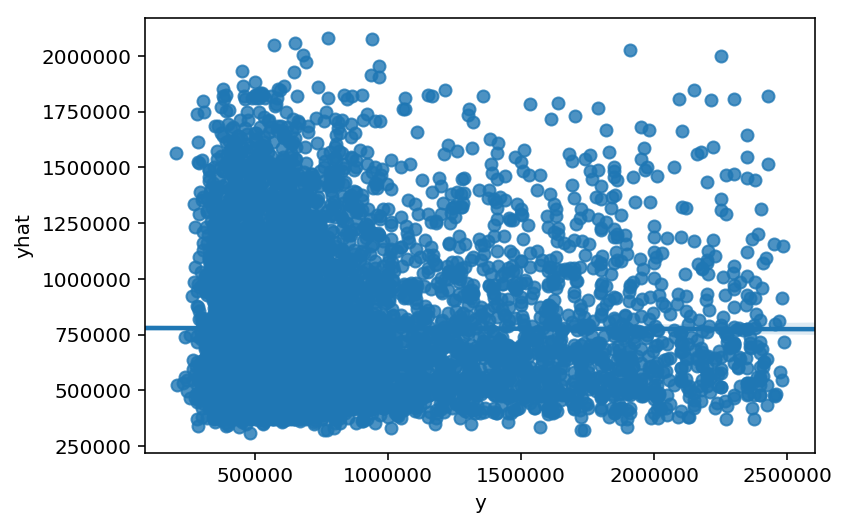

In [122]:
y = y
yh = clf.predict(Xtest)
result = pd.DataFrame([y,yh]).T
result.columns = ['y', 'yhat']
sns.regplot(x="y", y="yhat", data=result);

Good predict 0.128304108872


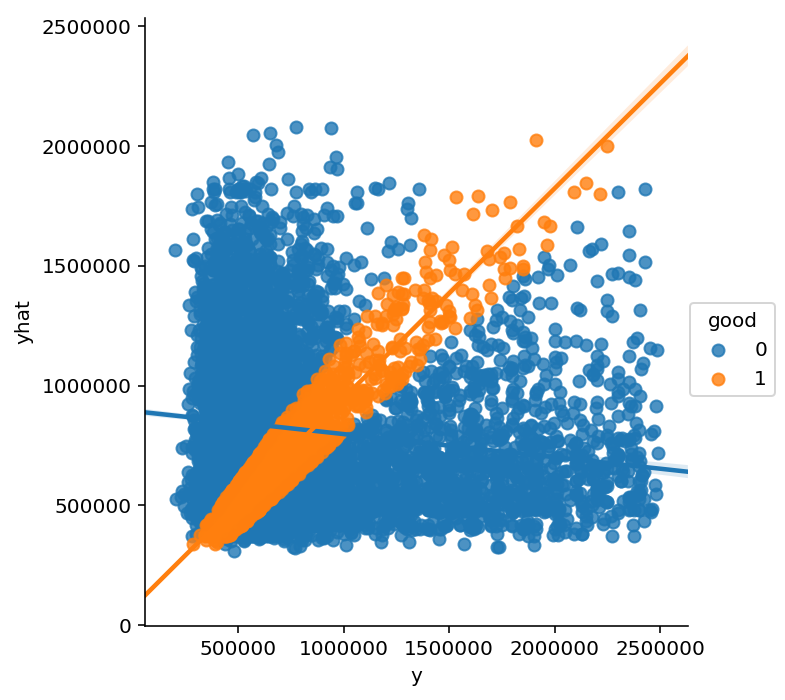

In [123]:
rf = result
rf['re'] = rf.y - rf.yhat
rf['res_pre'] = rf.re.astype(float) / rf.y
rf['good'] = rf.res_pre.map(lambda x: 1 if (x<=0.2) and (x>=-0.2) else 0)
print 'Good predict', float(rf[rf.good == 1].shape[0]) / rf.shape[0]
sns.lmplot(x="y", y="yhat", data=rf, hue='good');

## Add region feature

In [71]:
suburb = pd.read_csv('data/suburb_region.csv')
suburb.columns = ['suburb', 'post', 'region']
suburb.suburb = suburb.suburb.str.lower()
suburb.suburb = suburb.suburb.str.strip()
data = pd.merge(data, suburb, on='suburb', how='left')

In [72]:
region_dummies = pd.get_dummies(data.region, drop_first=True)

### Linear reg

In [73]:
X = pd.concat([region_dummies, 
               data[['landsize', 'park', 'bed', 'bath', 'Apartment', 'House', 'Townhouse', 'auction', 'treaty', 'dist2cbd']]], axis=1)
y = data.price.values
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.5, random_state=49)

ss = StandardScaler()
ss = ss.fit(Xtrain)

Xtrain = ss.transform(Xtrain)
Xtest = ss.transform(Xtest)

lr = LinearRegression()
print 'Mean of cross validation score (cv=10) for linear regression is', np.mean(cross_val_score(lr.fit(Xtrain, ytrain), Xtest, ytest, cv=10))

Mean of cross validation score (cv=10) for linear regression is 0.599977851835


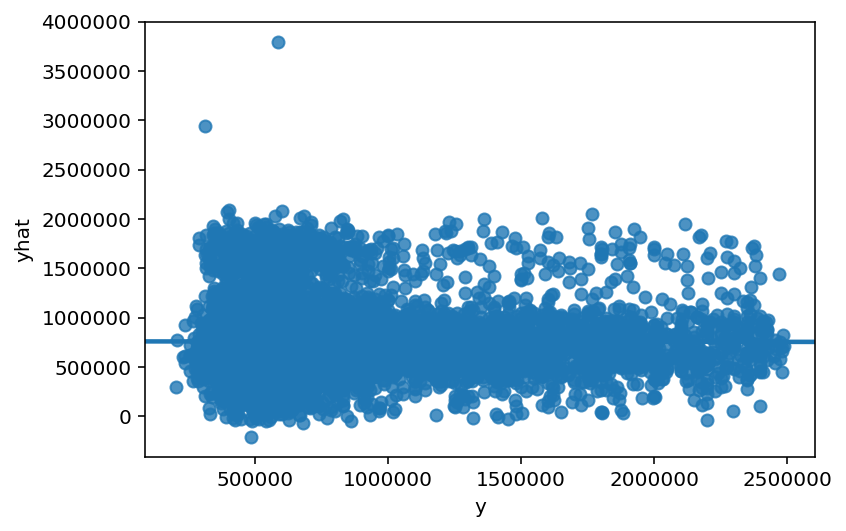

In [135]:
y = y
yh = lr.predict(Xtest)
result = pd.DataFrame([y,yh]).T
result.columns = ['y', 'yhat']
sns.regplot(x="y", y="yhat", data=result);

Good predict 0.129207127369


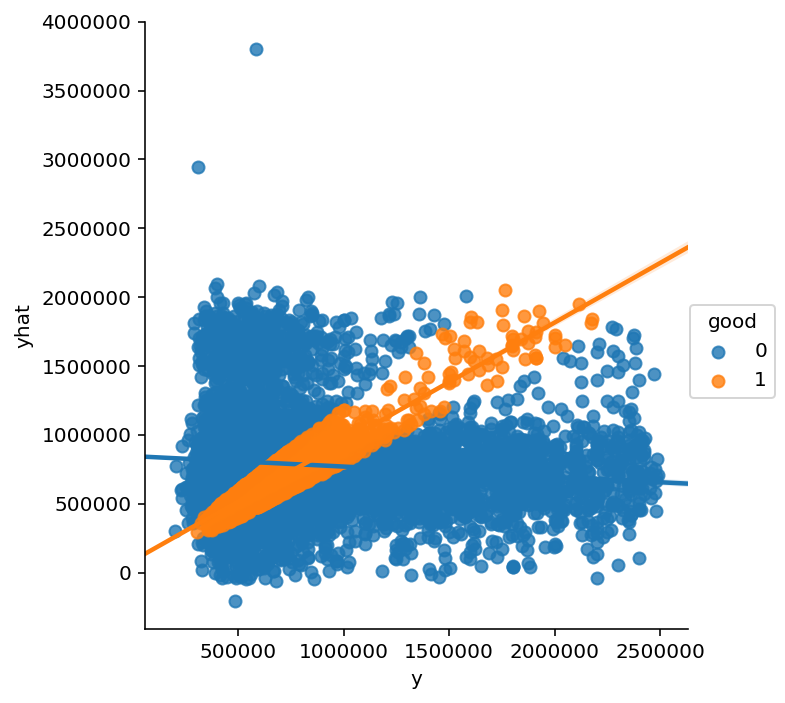

In [136]:
rf = result
rf['re'] = rf.y - rf.yhat
rf['res_pre'] = rf.re.astype(float) / rf.y
rf['good'] = rf.res_pre.map(lambda x: 1 if (x<=0.2) and (x>=-0.2) else 0)
print 'Good predict', float(rf[rf.good == 1].shape[0]) / rf.shape[0]
sns.lmplot(x="y", y="yhat", data=rf, hue='good');

### Gradient boosting reg

In [74]:
from sklearn.ensemble import GradientBoostingRegressor
clf = GradientBoostingRegressor(n_estimators=500, learning_rate=0.01, min_samples_split = 2,
                                 max_depth=4, random_state=0, loss='ls').fit(Xtrain, ytrain)
print 'Mean of cross validation score (cv=5) for gradient boosting regression is', np.mean(cross_val_score(clf, Xtest, ytest, cv=5))

Mean of cross validation score (cv=5) for gradient boosting regression is 0.758227369528


In [75]:
feature_import = pd.DataFrame([clf.feature_importances_], columns=X.columns).T
print 'Feature importance:'
feature_import.sort_values(0, ascending=False)

Feature importance:


,0
dist2cbd,0.350527
landsize,0.218493
Northern,0.129026
bath,0.094444
bed,0.051224
Western,0.036143
park,0.030195
treaty,0.025226
auction,0.015964
House,0.014640


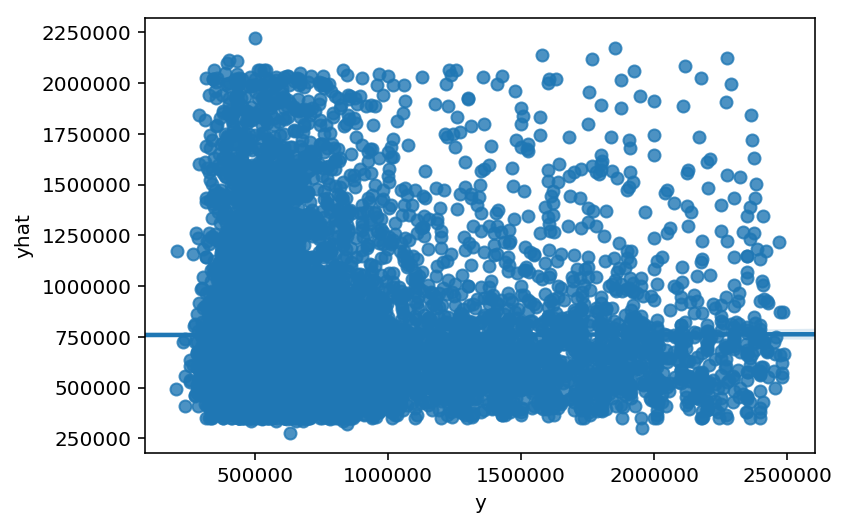

In [140]:
y = y
yh = clf.predict(Xtest)
result = pd.DataFrame([y,yh]).T
result.columns = ['y', 'yhat']
sns.regplot(x="y", y="yhat", data=result);

Good predict 0.142453097011


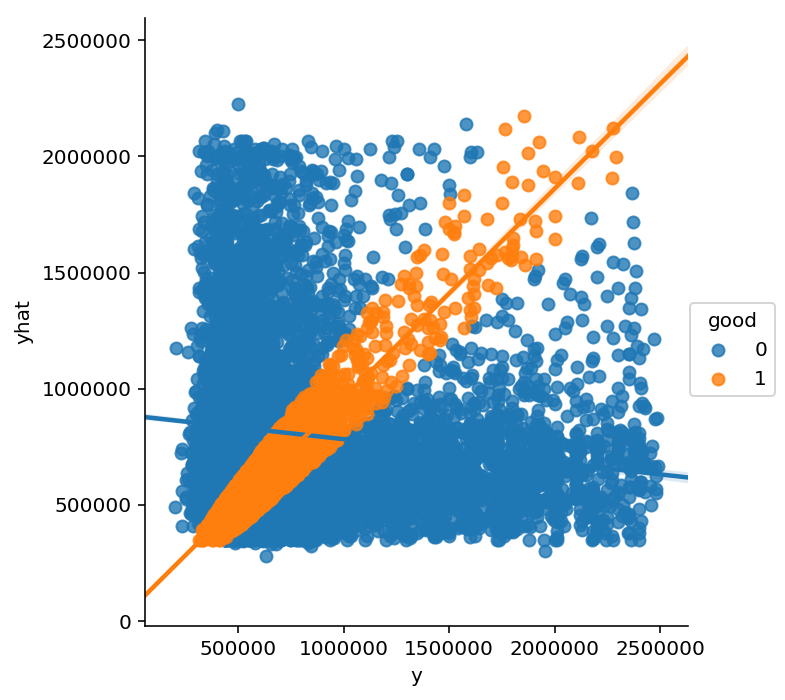

In [141]:
rf = result
rf['re'] = rf.y - rf.yhat
rf['res_pre'] = rf.re.astype(float) / rf.y
rf['good'] = rf.res_pre.map(lambda x: 1 if (x<=0.2) and (x>=-0.2) else 0)
print 'Good predict', float(rf[rf.good == 1].shape[0]) / rf.shape[0]
sns.lmplot(x="y", y="yhat", data=rf, hue='good');

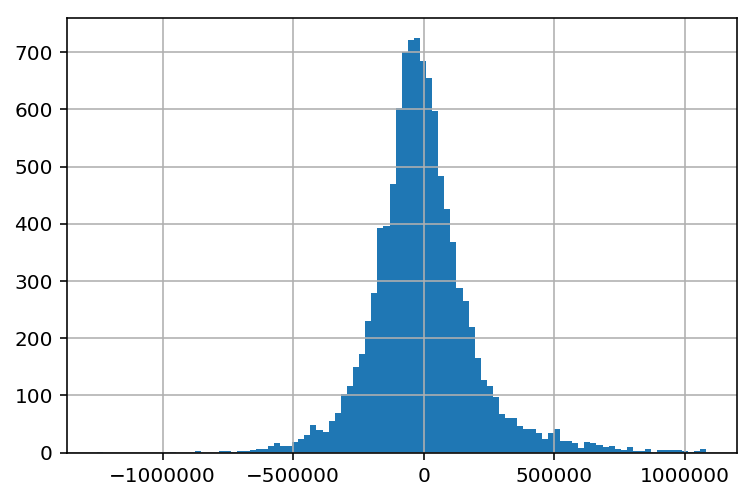

In [142]:
yh = clf.predict(Xtest)
c = pd.DataFrame([ytest, yh]).T
c['r'] = c[0] -c[1]
c.r.hist(bins=100);

### Decision tree reg

In [143]:
# reg tree
from sklearn.tree import DecisionTreeRegressor
regr = DecisionTreeRegressor(max_depth=12)
regr.fit(Xtrain, ytrain)
print 'Mean of cross validation score (cv=5) for decision tree regression is', np.mean(cross_val_score(regr, Xtest, ytest, cv=5))

Mean of cross validation score (cv=5) for decision tree regression is 0.671397597639


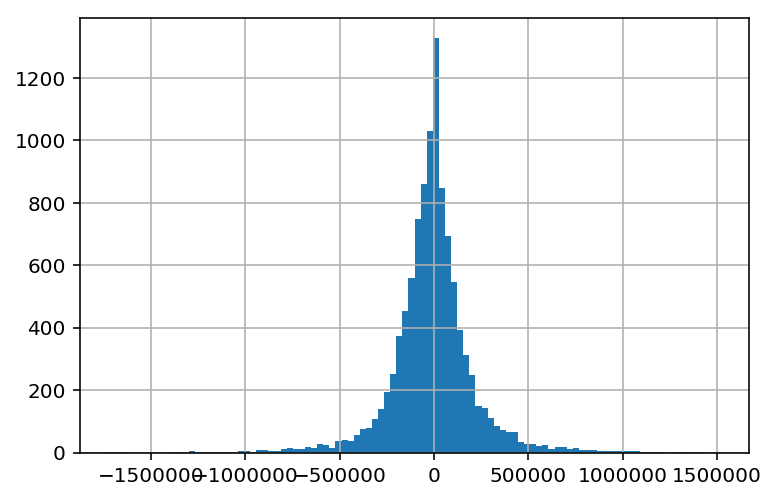

In [144]:
yh = regr.predict(Xtest)
c = pd.DataFrame([ytest, yh]).T
c['r'] = c[0] -c[1]
c.r.hist(bins=100);

### KNN reg

In [145]:
from sklearn import neighbors

knn = neighbors.KNeighborsRegressor(n_neighbors=5, weights='distance')
knn.fit(Xtrain, ytrain)
print 'Mean of cross validation score (cv=5) for KNN regression is', np.mean(cross_val_score(knn, Xtest, ytest, cv=5))

Mean of cross validation score (cv=5) for KNN regression is 0.716513133947


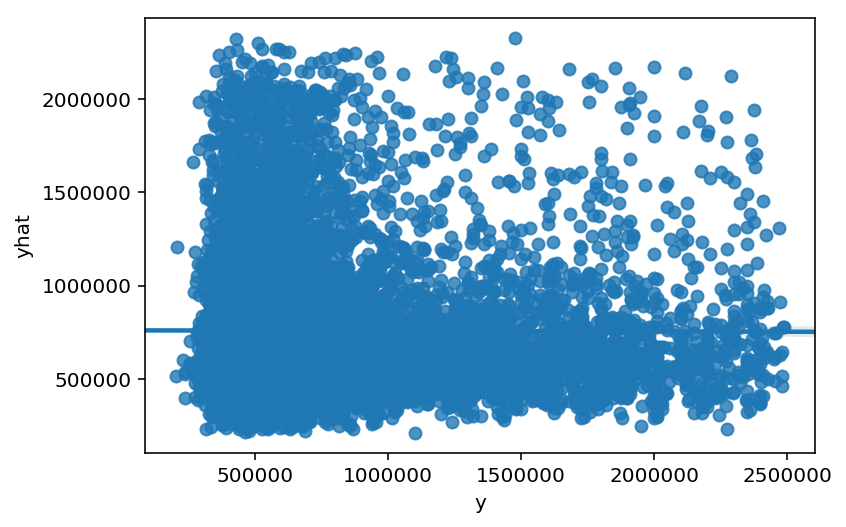

In [155]:
y = y
yh = knn.predict(Xtest)
result = pd.DataFrame([y,yh]).T
result.columns = ['y', 'yhat']
sns.regplot(x="y", y="yhat", data=result);

Good predict 0.134580937117


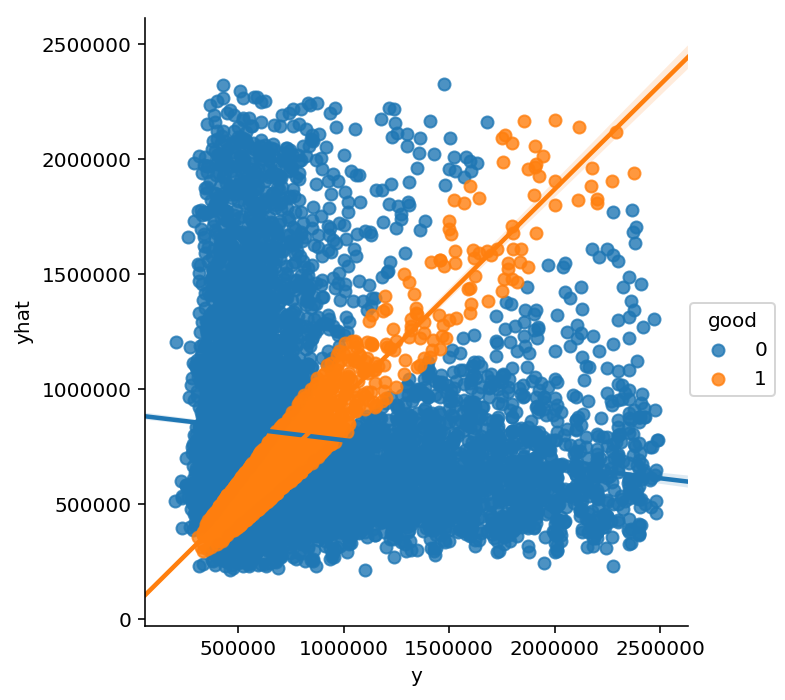

In [156]:
rf = result
rf['re'] = rf.y - rf.yhat
rf['res_pre'] = rf.re.astype(float) / rf.y
rf['good'] = rf.res_pre.map(lambda x: 1 if (x<=0.2) and (x>=-0.2) else 0)
print 'Good predict', float(rf[rf.good == 1].shape[0]) / rf.shape[0]
sns.lmplot(x="y", y="yhat", data=rf, hue='good');

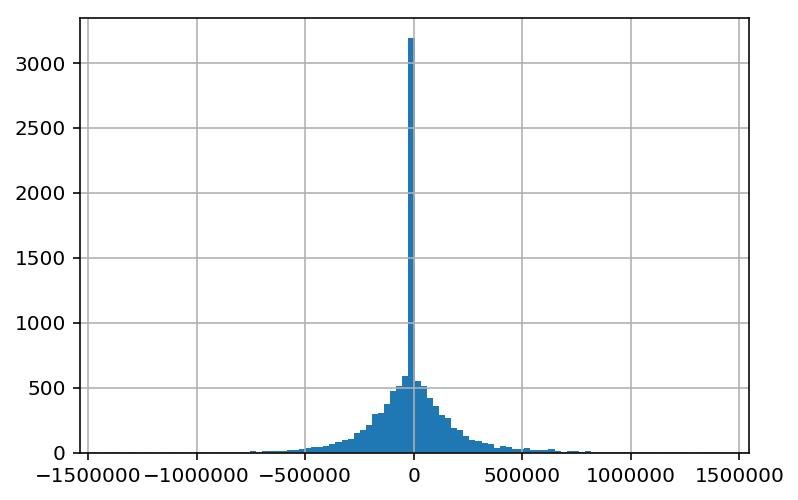

In [146]:
yh = knn.predict(Xtest)
c = pd.DataFrame([ytest, yh]).T
c['r'] = c[0] -c[1]
c.r.hist(bins=100);

### Random forest regression

In [147]:
from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor(max_depth=6, random_state=0)
rfr.fit(Xtrain, ytrain)
print 'Mean of cross validation score (cv=5) for random forest regression is', np.mean(cross_val_score(regr, Xtest, ytest, cv=5))

Mean of cross validation score (cv=5) for random forest regression is 0.67228473186


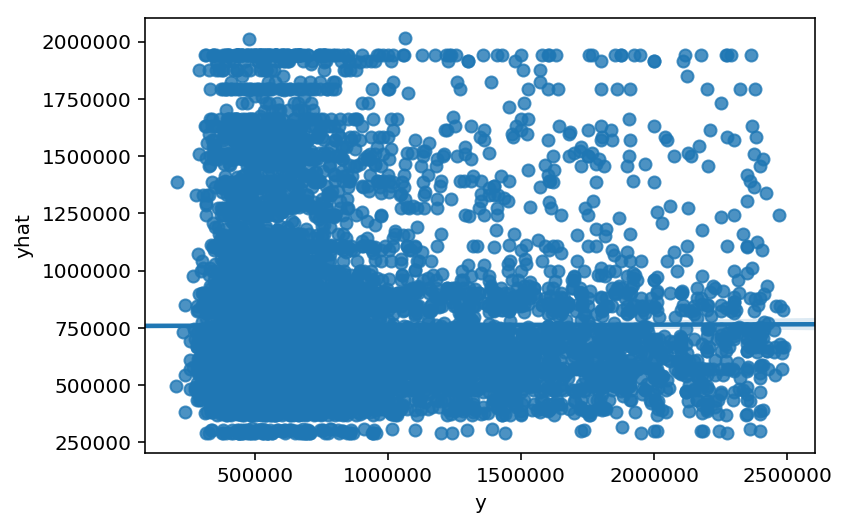

In [157]:
y = y
yh = rfr.predict(Xtest)
result = pd.DataFrame([y,yh]).T
result.columns = ['y', 'yhat']
sns.regplot(x="y", y="yhat", data=result);

Good predict 0.141510323371


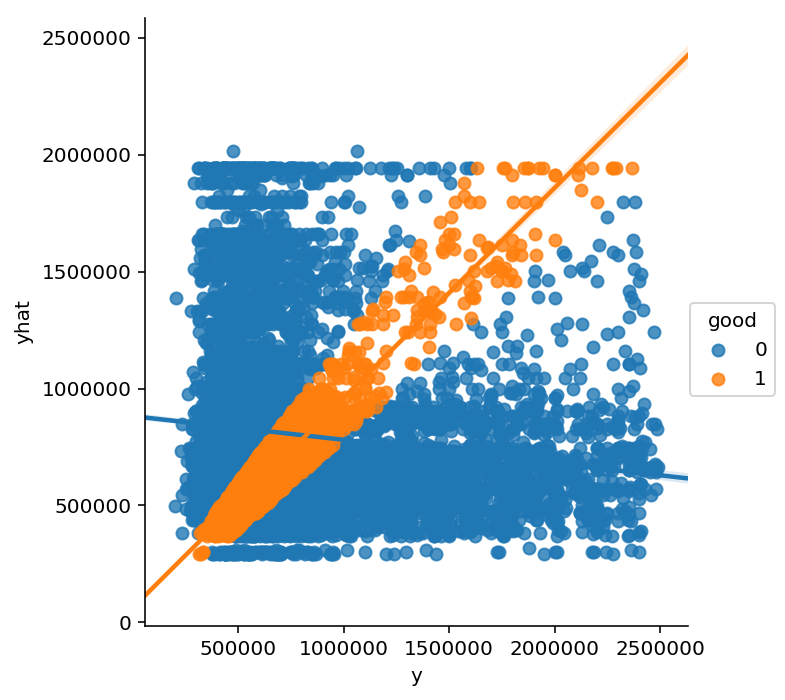

In [158]:
rf = result
rf['re'] = rf.y - rf.yhat
rf['res_pre'] = rf.re.astype(float) / rf.y
rf['good'] = rf.res_pre.map(lambda x: 1 if (x<=0.2) and (x>=-0.2) else 0)
print 'Good predict', float(rf[rf.good == 1].shape[0]) / rf.shape[0]
sns.lmplot(x="y", y="yhat", data=rf, hue='good');

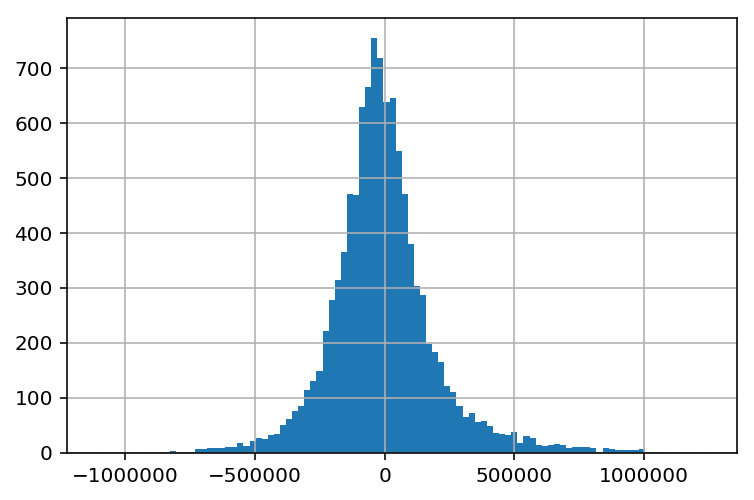

In [148]:
yh = rfr.predict(Xtest)
c = pd.DataFrame([ytest, yh]).T
c['r'] = c[0] -c[1]
c.r.hist(bins=100);

## Add suburb feature

## Focusing on House

In [152]:
# house = data[data.Apartment == 0]
# rd = pd.get_dummies(house.region)
# house.shape

In [151]:
# X = pd.concat([rd, 
#                house[['landsize', 'park', 'bed', 'bath', 'House', 'Townhouse', 'auction', 'treaty']]], axis=1)
# y = house.price.values
# Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.5, random_state=49)

# ss = StandardScaler()
# ss = ss.fit(Xtrain)

# Xtrain = ss.transform(Xtrain)
# Xtest = ss.transform(Xtest)

# lr = LinearRegression()
# print 'Mean of cross validation score (cv=5) for Linear regression is', np.mean(cross_val_score(lr.fit(Xtrain, ytrain), Xtest, ytest, cv=5))

In [150]:
# from sklearn.ensemble import GradientBoostingRegressor
# clf = GradientBoostingRegressor(n_estimators=500, learning_rate=0.01, min_samples_split = 2,
#             max_depth=4, random_state=0, loss='ls').fit(Xtrain, ytrain)
# print 'Mean of cross validation score (cv=5) for Grandient Boosting regression is', np.mean(cross_val_score(clf, Xtest, ytest, cv=5))

In [149]:
# knn = neighbors.KNeighborsRegressor(12, weights='distance')
# knn.fit(Xtrain, ytrain)
# print 'Mean of cross validation score (cv=5) for KNN regression is', np.mean(cross_val_score(knn, Xtest, ytest, cv=5))

# Summary

Important features including:
- Distance to CBD
- Landsize
- Number of bathroom 

Best fit model: Gradient Boosting regression.

# Limitation

1. Static models, not including time feature.
- No feature related to house quality.
- Local neighbor environment is hard to measure.

# Flask app (Demo)

Flask + AngularJS -> Find Similar Hose based on condition.

# Reference

1. http://resources.point.com/8-biggest-factors-affect-real-estate-prices/
- http://www.kdnuggets.com/2016/10/beginners-guide-neural-networks-python-scikit-learn.html
- http://scikit-learn.org/stable/auto_examples/tree/plot_tree_regression.html
- http://scikit-learn.org/stable/auto_examples/neighbors/plot_regression.html